In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
import os

# Cheminformatics stack
import rdkit
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem import FragmentMatcher
from rdkit.Chem import rdFMCS
from glob import glob

# For segfault
import faulthandler
import signal
from subprocess import Popen, PIPE
from rdkit.Chem import rdMMPA
def fragment_mols_to_3_parts(mols_list):
    """
    This function takes a list of molecules and fragments them into 3 parts: left block, linker and right block.
    The function returns 3 dataframes, one for each part.
    Parameters:
    mols_list: list of RDKit molecules
    """
    linker_list = []
    Left_block = []
    Right_block = []
    for mols in mols_list:
        frag3 = rdMMPA.FragmentMol(mols)

        for frag in frag3:
            if frag[0] is not None:
                #display(Draw.MolsToGridImage(frag3[1]))
                frag_smiles_ = Chem.MolToSmiles(frag[1]).split('.')
                if len(frag_smiles_) == 2:
                    linker_list.append(frag[0])
                    
                    if '*:1' in frag_smiles_[0]:
                        Left_block.append( Chem.MolFromSmiles(frag_smiles_[0]))
                        Right_block.append( Chem.MolFromSmiles(frag_smiles_[1]))
                    else:
                        Left_block.append( Chem.MolFromSmiles(frag_smiles_[1]))
                        Right_block.append( Chem.MolFromSmiles(frag_smiles_[0]))
    print(' number of linkers:', len(linker_list))  
    print(' number of left blocks:', len(Left_block))
    print(' number of right blocks:', len(Right_block))
    df_linkers= pd.DataFrame({'linker':linker_list, 'smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    df_linkers.drop_duplicates(subset=['smiles'],inplace=True) 
    print(' number of unique linkers:', df_linkers.shape[0])
    df_linkers.head()
    df_right_block = pd.DataFrame({'right_block':Right_block, 'smiles': [Chem.MolToSmiles(m) for m in Right_block],'linkers_smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    #df_right_block.drop_duplicates(subset=['smiles'],inplace=True)
    print(' number of unique right blocks:', df_right_block.shape[0])
    df_left_block = pd.DataFrame({'left_block':Left_block, 'smiles': [Chem.MolToSmiles(m) for m in Left_block],'linkers_smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    #df_left_block.drop_duplicates(subset=['smiles'],inplace=True)
    print(' number of unique left blocks:', df_left_block.shape[0])
    return df_linkers, df_left_block, df_right_block
def load_smiles_file(smiles_file):
    """
    This function loads a file containing SMILES and returns a dataframe with the SMILES and the RDKit molecule object.
    Parameters:
    smiles_file: string, path to the file containing the SMILES
    """
    df = pd.read_csv(smiles_file, header=None, names=['smiles'])
    df.drop_duplicates(subset=['smiles'], inplace=True)
    df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)
    df.dropna(inplace=True)
    print(' number of molecules in file:', df.shape[0])
    return df
def load_smiles_file_txt(smiles_file):
    """
    This function loads a file containing SMILES and returns a dataframe with the SMILES and the RDKit molecule object.
    Parameters:
    smiles_file: string, path to the file containing the SMILES
    """
    df = pd.read_csv(smiles_file,delimiter='\t')
    df.drop_duplicates(subset=['smiles'], inplace=True)
    df['smiles'] = df['smiles'].apply(lambda x: x.split('<TAB>')[0])

    df['mol'] = df['smiles'].apply(Chem.MolFromSmiles)

    df.dropna(inplace=True)
    print(' number of molecules in file:', df.shape[0])
    return df

 number of molecules in file: 33


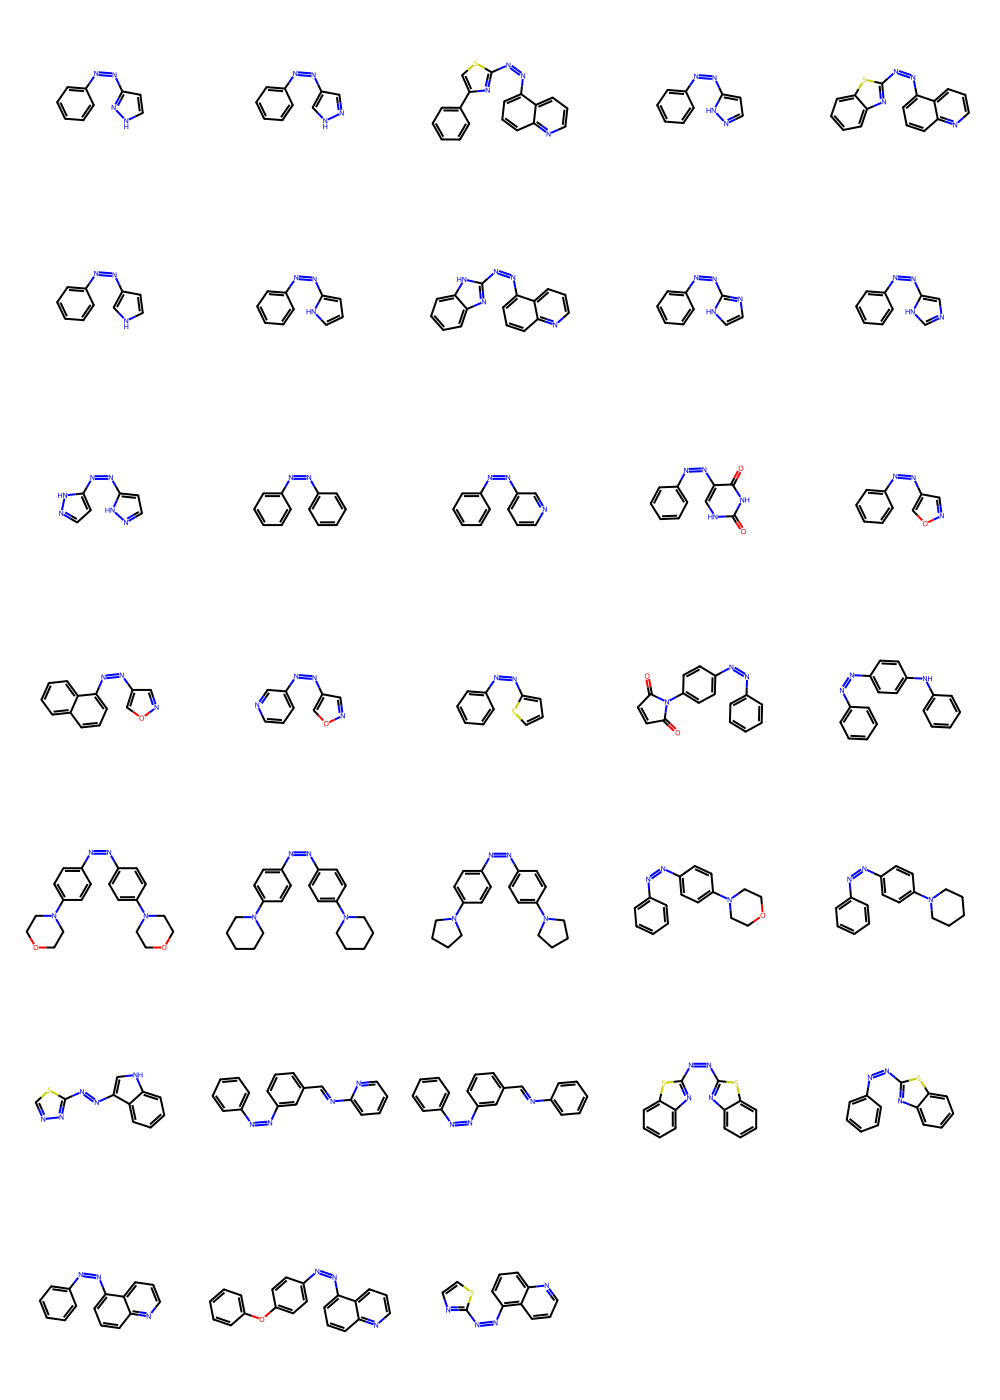

In [29]:
smiles_file = 'Smiles_OFF-ON_database/Smiles_OFF-ON_database/2_Murcko.smiles'
smiles_file = '2_murcko_only_azo_cores.txt'
df_smiles = load_smiles_file_txt(smiles_file)
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(df_smiles['mol'][:50], molsPerRow=5, subImgSize=(200,200))
df_smiles.to_csv('2_murcko.csv')
img

989
582
33


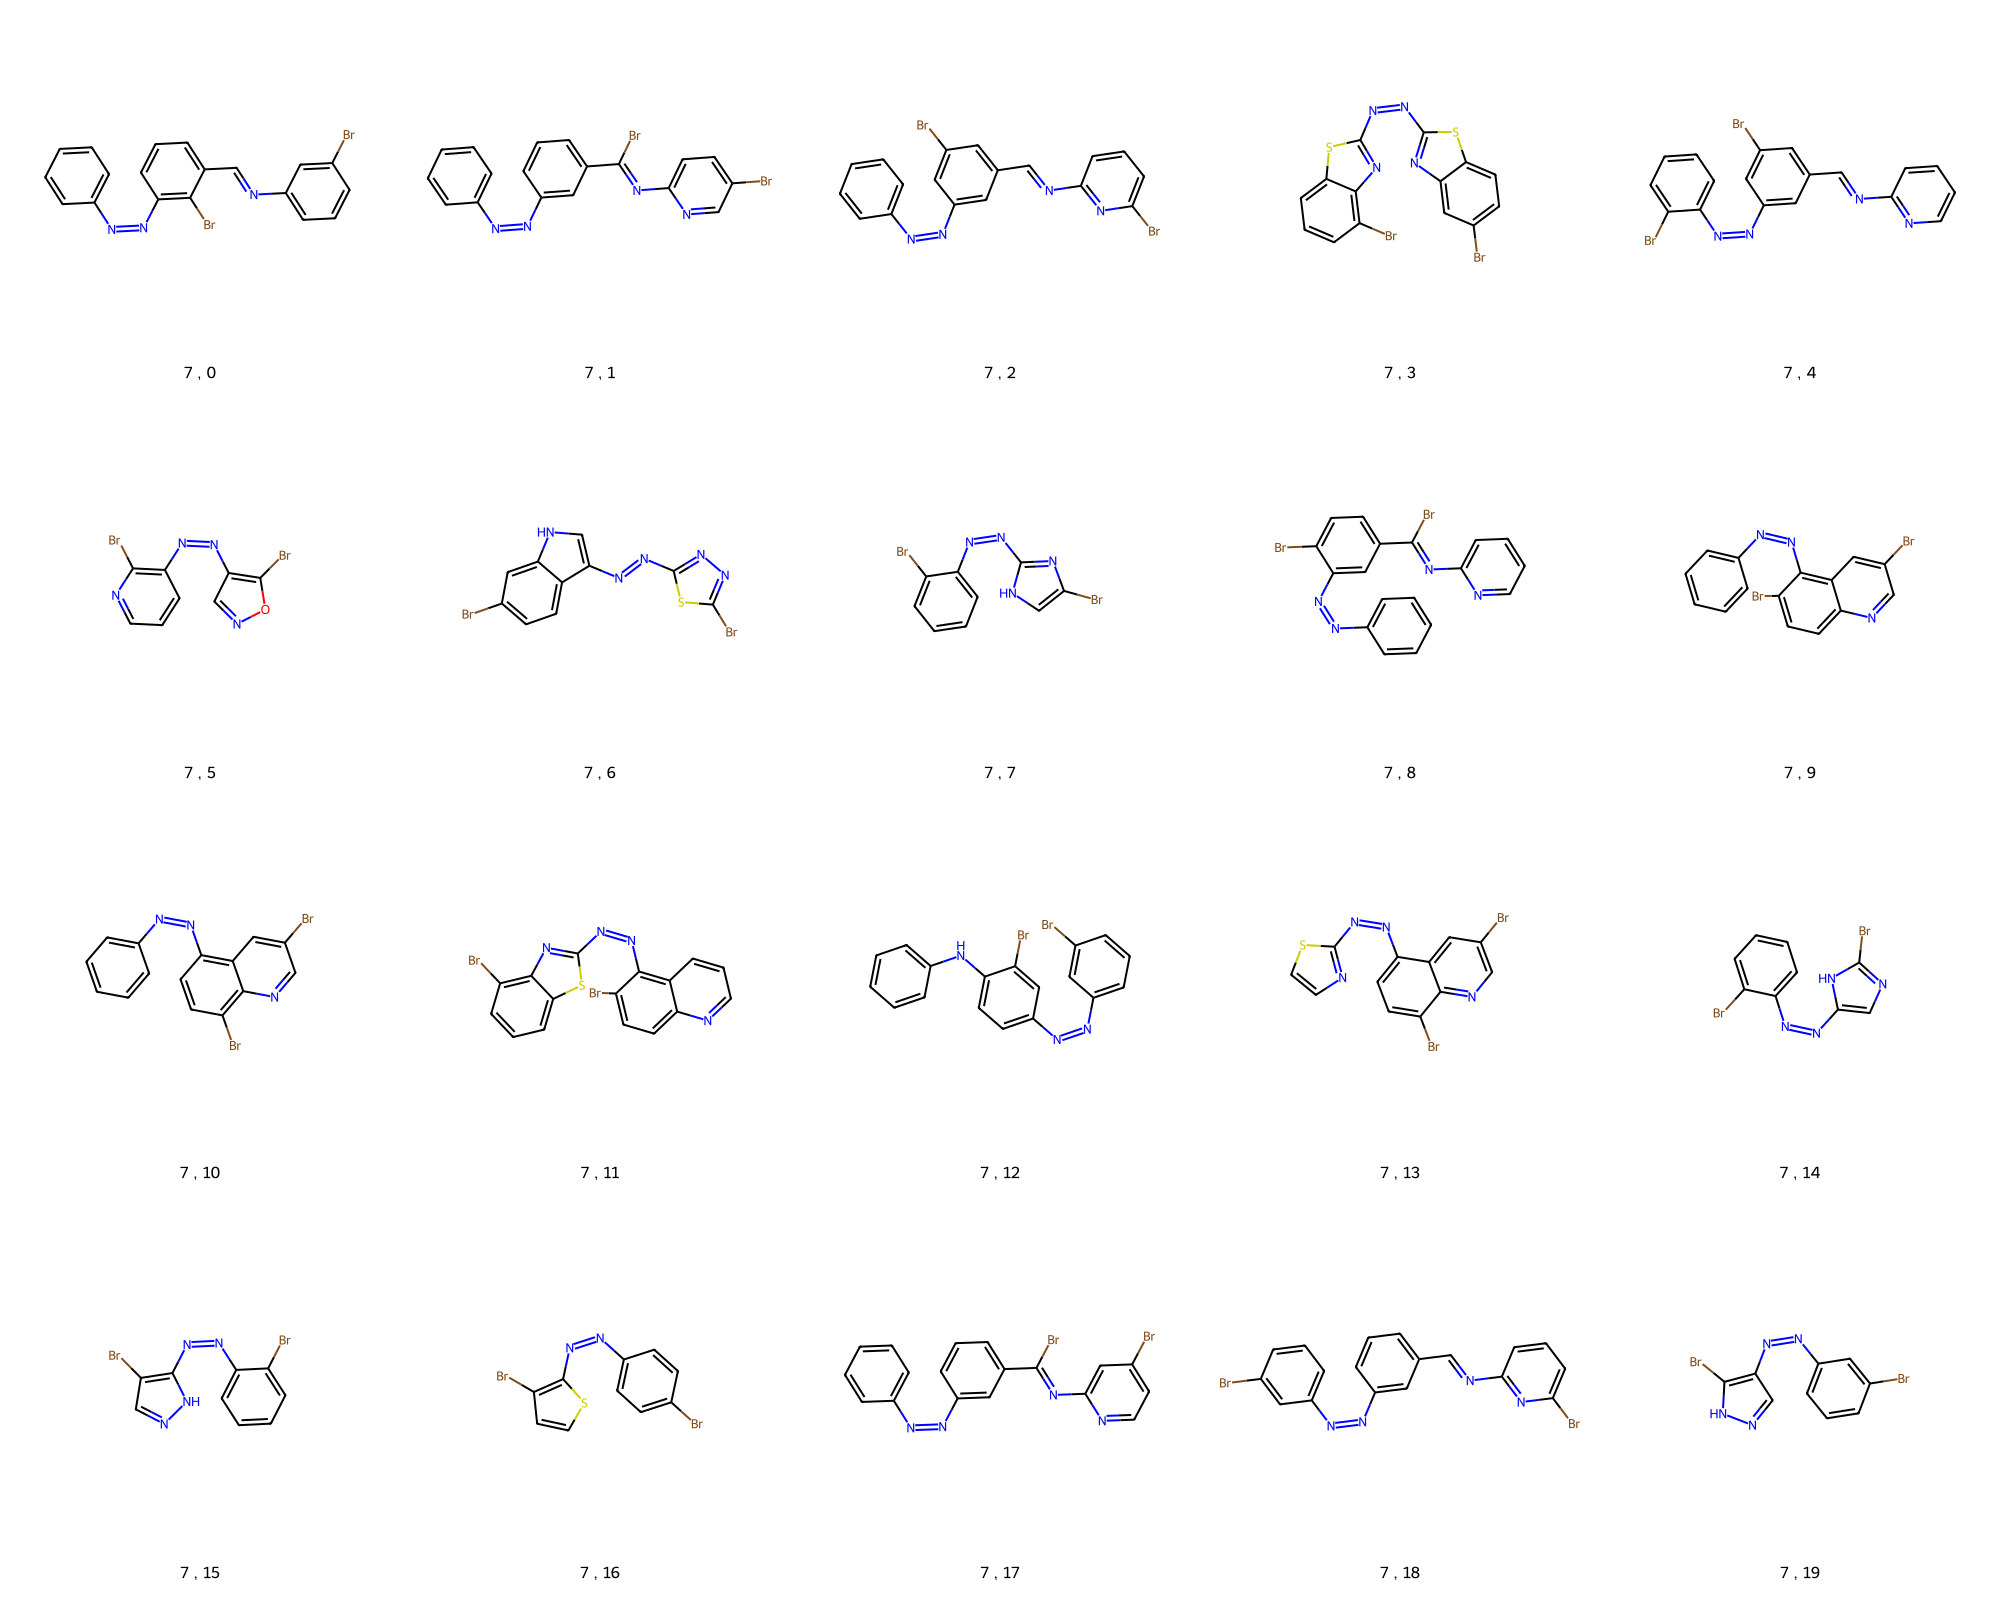

In [53]:
# helper function to define building blocks from fragments
import itertools
from rdkit.Chem import rdMolDescriptors
from rdkit import Chem
def fragment_from_smiles(smile):
    """
    This function takes a SMILES string as the initial molecular fragment and returns a list of RDKit molecules for the building blocks.
    Here we place a bromin atoms to identify the potential connection points.
    the building of an oligomer would use the stk.bromoFactory to connect the building blocks. 
     https://stk.readthedocs.io/en/stable/_autosummary/stk.BromoFactory.html#
    Parameters
    ----------
    smile : str
        SMILES string

    Returns
    -------
    mol_list : list
        list of RDKit molecules
    mol_list_smiles : list
        list of SMILES strings
    """

    mol2=Chem.MolFromSmiles(smile)
    mol2=Chem.AddHs(mol2)

    potential_connection=[]
    for x in mol2.GetAtoms():
        #print(x.GetIdx(), x.GetHybridization())
        #if x.GetAtomicNum() == 35 or x.GetAtomicNum() == 34 or x.GetAtomicNum() == 14 or x.GetAtomicNum() == 17:
         #   return [],[],[]
        if  x.GetHybridization().name == 'SP2': # x.GetAtomicNum() == 6 and
            for atom in x.GetNeighbors():
                if atom.GetAtomicNum() == 1:
                    potential_connection.append(atom.GetIdx())#atom.SetAtomicNum(35)
    mol_list = []
    mol_list_smiles=[]
    potential_connection=list(set(potential_connection))
    #print(potential_connection)
    #print(len(set(itertools.combinations(potential_connection, 2))))
    for atom1,atom2 in set(itertools.combinations(potential_connection, 2)):
        mol_trans=Chem.Mol(mol2)
        pass_case=False
        # add condition for the case where the two atoms are on the same ring
        #if atom1 in [x.Get
        
        Neighbour_atom1 = mol_trans.GetAtoms()[atom1].GetNeighbors()
        Neighbour_atom2 = mol_trans.GetAtoms()[atom2].GetNeighbors()
        for atom1_N in Neighbour_atom1:
            for atom2_N in Neighbour_atom2:
                if atom1_N.GetIdx() == atom2_N.GetIdx():
                    pass_case=True
                    break
                if atom1_N.GetIdx() in [x.GetIdx() for x in atom2_N.GetNeighbors()]:
                    pass_case=True
                    break
                if len(set([x.GetIdx() for x in atom1_N.GetNeighbors()])\
                    .intersection(set([x.GetIdx() for x in atom2_N.GetNeighbors()])))>0:
                    pass_case=True
                    break
        if pass_case:
            continue
        mol_trans.GetAtoms()[atom1].SetAtomicNum(35)
        mol_trans.GetAtoms()[atom2].SetAtomicNum(35)
        mol_list.append(mol_trans)
        mol_list_smiles.append(Chem.MolToSmiles(mol_trans))
    return mol_list,mol_list_smiles, [smile]
mol_list_smiles_all=[]
mol_list_all=[]
org_smiles=[]

for count,smiles in enumerate(df_smiles['smiles']):
    mol=Chem.MolFromSmiles(smiles)
    if mol.GetNumAtoms()<30:
        mol_list,mol_list_smiles,smile=fragment_from_smiles(smiles)
        mol_list_smiles_all+=mol_list_smiles
        mol_list_all+=mol_list
        org_smiles+=smile

    #if count>12:
     #   break
print(len(mol_list_smiles_all))
mol_list_all = [Chem.MolFromSmiles(smile) for smile in set(mol_list_smiles_all)]
mol_list_all_org = [Chem.MolFromSmiles(smile) for smile in set(org_smiles)]
pd_photochromic = pd.DataFrame({'smiles':mol_list_smiles_all})
pd_photochromic.drop_duplicates(subset=['smiles'],inplace=True)
pd_photochromic.to_csv('2_murcko_azo_photo_cores_Br.csv')
print(len(set(mol_list_smiles_all)))
print(len(set(org_smiles)))
img=Draw.MolsToGridImage(mol_list_all[:20],molsPerRow=5,subImgSize=(400,400),returnPNG=False,legends=[f"7 , {index}" for index, x in enumerate(mol_list_all)])    
img


In [50]:
bond

In [49]:
for atom1,atom2 in set(itertools.combinations( mol.GetAtoms(), 2)):    
    bond = mol.GetBondBetweenAtoms(atom1.GetIdx() , atom2.GetIdx())
    print(bond.IsInRing())  

AttributeError: 'NoneType' object has no attribute 'IsInRing'

[16:26:17] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 15 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 8 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 5 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 4 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 6 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 1 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 0 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 2 N, 4, is greater than permitted
[16:26:17] Can't kekulize mol.  Unkekulized atoms: 3 4 8
[16:26:17] Explicit valence for atom # 3 N, 4, is greater than permitted
[16:26:17] Explicit valence for atom # 0 C, 5, is greater than per

 number of molecules in file: 3298


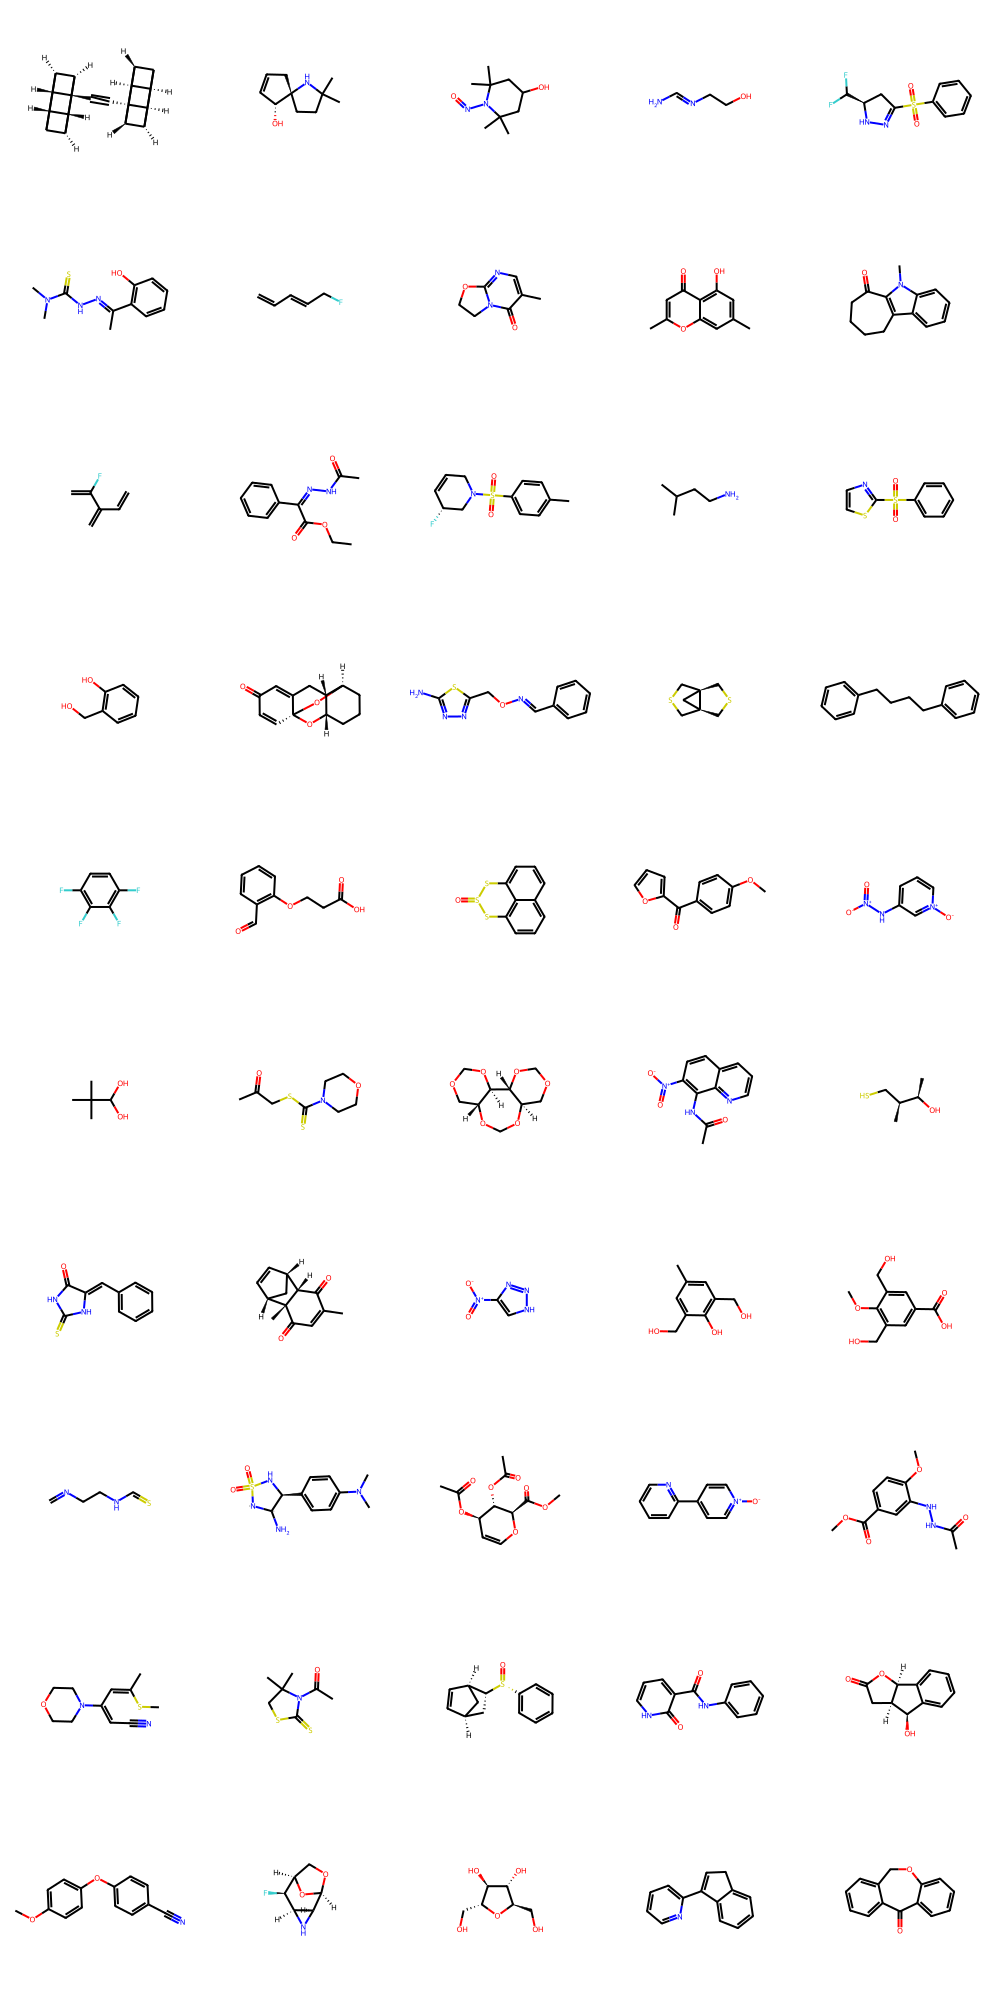

In [27]:
smiles_file = 'Smiles_OFF-ON_database/Smiles_OFF-ON_database/1_Sergi.smiles'
df_smiles = load_smiles_file(smiles_file)
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(df_smiles['mol'][:50], molsPerRow=5, subImgSize=(200,200))
img

In [6]:
df_smiles


,smiles,mol


In [10]:
df_linkers, df_left_block, df_right_block = fragment_mols_to_3_parts(df_smiles['mol'])
print('Linkers')
display(Draw.MolsToGridImage(df_linkers['linker'][:10]))
print('Right blocks')
display(Draw.MolsToGridImage(df_right_block['right_block'][:10]))
print('Left blocks')
display(Draw.MolsToGridImage(df_left_block['left_block'][:10]))


 number of linkers: 1744
 number of left blocks: 1744
 number of right blocks: 1744
 number of unique linkers: 519
 number of unique right blocks: 1744
 number of unique left blocks: 1744


Linkers


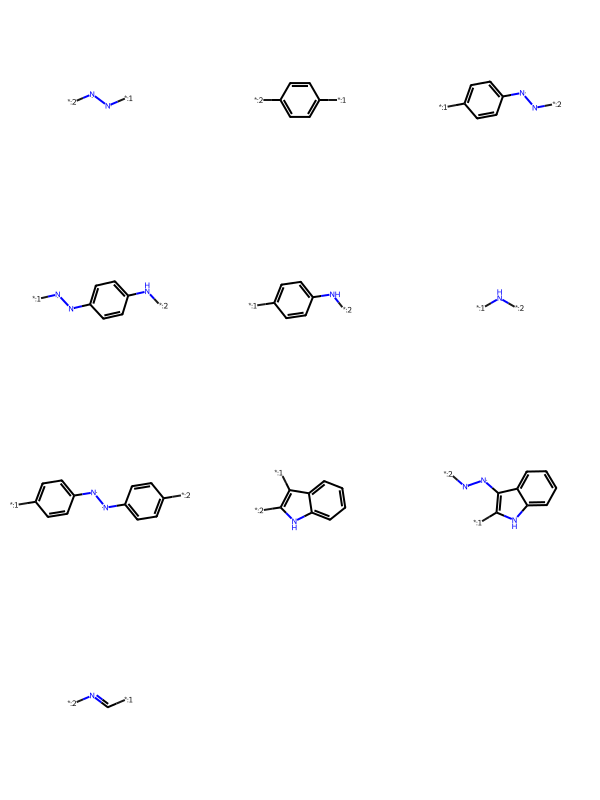

Right blocks


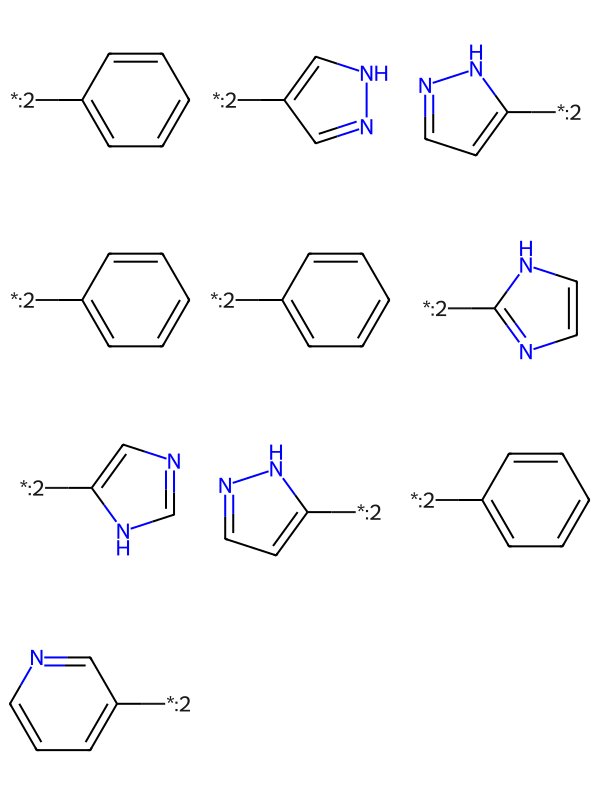

Left blocks


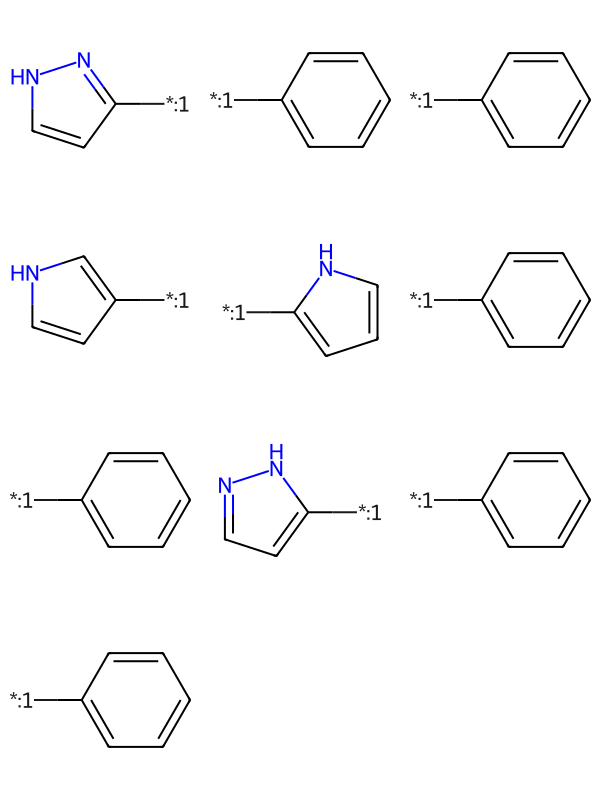

In [11]:
print('Linkers')
display(Draw.MolsToGridImage(df_linkers['linker'][:10]))
print('Right blocks')
display(Draw.MolsToGridImage(df_right_block['right_block'][:10]))
print('Left blocks')
display(Draw.MolsToGridImage(df_left_block['left_block'][:10]))



In [12]:
df_linkers_csv = df_linkers[['smiles']]
df_linkers_csv.to_csv('linkers.csv', index=False)

In [14]:
# read text file
df_linker_filtered = pd.read_csv('linkers_170724_filtered.txt',delimiter='\t')
df_left_block_filtered = df_left_block[df_left_block['linkers_smiles'].isin(df_linker_filtered['smiles'])]
df_left_block_filtered_csv = df_left_block_filtered[['smiles','linkers_smiles']]
df_left_block_filtered_csv.to_csv('left_blocks_all_linkers.csv', index=False)

In [22]:
df_left_block_filtered_csv.groupby('linkers_smiles').count().to_csv('linkers_count_170724.csv')

In [24]:
# read text file
df_linker_filtered = pd.read_csv('linkers_170724_filtered.txt',delimiter='\t')
df_right_block_filtered = df_right_block[df_left_block['linkers_smiles'].isin(df_linker_filtered['smiles'])]
df_right_block_filtered_csv = df_right_block_filtered[['smiles','linkers_smiles']]
df_right_block_filtered_csv.to_csv('right_blocks_all_linkers.csv', index=False)
df_right_block_filtered_csv_U = df_right_block_filtered[['smiles','linkers_smiles']]
df_right_block_filtered_csv_U.drop_duplicates(subset='smiles',inplace=True)
df_right_block_filtered_csv_U.to_csv('right_blocks_all_linkers_unique.csv', index=False)
df_right_block_filtered_csv.groupby('linkers_smiles').count().to_csv('linkers_count_170724_right.csv')

C:\Users\ma11115\AppData\Local\Temp\ipykernel_11668\811699480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_right_block_filtered_csv_U.drop_duplicates(subset='smiles',inplace=True)


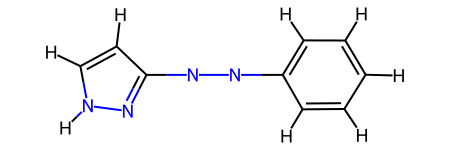

In [126]:
import stk
def build_molecule_from_frag(right_block, left_block, linker):
    """
    This function takes the 3 fragments and builds a molecule using the STK library.
    Parameters:
    right_block: RDKit molecule, right block
    left_block: RDKit molecule, left block
    linker: RDKit molecule, linker

    """
    right_block_smiles = Chem.MolToSmiles(right_block)
    right_block_smiles = right_block_smiles.replace('[*:2]', 'Br')
    bb_right = stk.BuildingBlock(
            smiles= right_block_smiles, functional_groups=[stk.BromoFactory()]
            )
    left_block_smiles = Chem.MolToSmiles(left_block)
    left_block_smiles = left_block_smiles.replace('[*:1]', 'Br')
    bb_left = stk.BuildingBlock(
            smiles= left_block_smiles, functional_groups=[stk.BromoFactory()]
            )
    linker_smiles = Chem.MolToSmiles(linker)
    linker_smiles = linker_smiles.replace('[*:1]', 'Br')
    linker_smiles = linker_smiles.replace('[*:2]', 'Br')
    bb_linker = stk.BuildingBlock(
            smiles= linker_smiles, functional_groups=[stk.BromoFactory()]
            )
    constructed_molecule = stk.ConstructedMolecule(
            stk.polymer.Linear(
                building_blocks=[bb_left, bb_linker, bb_right],
                repeating_unit="ABC",
                num_repeating_units=1,
                optimizer=stk.MCHammer()
            )
        )
    return constructed_molecule
right_block = df_right_block['right_block'].iloc[0]
left_block = df_left_block['left_block'].iloc[0]
linker = df_linkers['linker'].iloc[0]
constructed_molecule = build_molecule_from_frag(right_block, left_block, linker)
constructed_molecule.to_rdkit_mol()

# test stuff


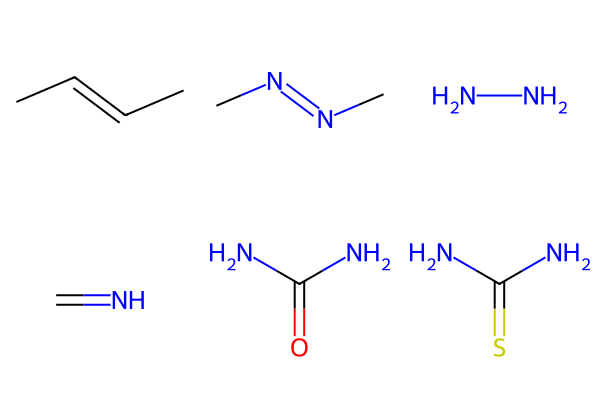

In [4]:
# Classification rules


patterns = [
    #"C=C",
    "CC=CC",
    "CN=NC",
    "NN",
    #"N=C",
    "C=N",
    #'NN',
    "NC(N)=O",
    "NC(N)=S",
]
# draw mol patterns
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns], dtype=object)
from rdkit import Chem
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mol_patterns, molsPerRow=3)
img

In [5]:
# Method 2 using FragmentMatchers
def initialise_matchers(patterns):
    pmatchers = [FragmentMatcher.FragmentMatcher() for p in patterns]
    for p, pm in zip(patterns, pmatchers):
        pm.Init(p)
        for p2 in patterns:
            if p2 is not p:
                #pm.AddExclusion(p2)
                continue
                #print(f"Added exclusion for {p2}")
    return pmatchers
def generate_unique_frag(mol,patterns):
    fragsmiles, fragmols, fragaps, fraparent, fraparentmol = [], [], [], [], []
    pmatchers = initialise_matchers(patterns)
    for j, pm in enumerate(pmatchers):
        if pm.HasMatch(mol):
            #print(f"{csmiles[i]} seems to contain {patterns[j]}")
            #moltype[i] = j + 1
            matches = pm.GetMatches(mol)
            bonds_to_cut = []
            for idx in matches[0]:
                for n in mol.GetAtomWithIdx(idx).GetNeighbors():
                    nidx = n.GetIdx()
                    if nidx not in matches[0]:
                        bonds_to_cut.append(mol.GetBondBetweenAtoms(idx, nidx))
            if bonds_to_cut:
                posi_ids = [b.GetBeginAtomIdx() for b in bonds_to_cut]
                pose_ids = [b.GetEndAtomIdx() for b in bonds_to_cut]
                bond_ids = [b.GetIdx() for b in bonds_to_cut]
                temp_mol_f = Chem.FragmentOnBonds(mol, bond_ids, addDummies=False)
                fmols = Chem.GetMolFrags(temp_mol_f, asMols=True)
                fatoms = Chem.GetMolFrags(temp_mol_f)
                for fmol, fatom in zip(fmols, fatoms):
                    fatom = list(fatom)
                    if not pm.HasMatch(fmol):
                        fragsmiles.append(Chem.MolToSmiles(fmol))
                        fragmols.append(fmol)
                        # print(posi_ids, pose_ids, fatom)
                        if any(a in posi_ids for a in fatom):
                            for pos in posi_ids:
                                if pos in fatom:
                                    fatom_ap_idx = list(fatom).index(pos)
                        elif any(a in pose_ids for a in fatom):
                            for pos in pose_ids:
                                if pos in fatom:
                                    fatom_ap_idx = list(fatom).index(pos)
                        fragaps.append(fatom_ap_idx)
                        #fraparent.append(names[i])
                        fraparentmol.append(mol)
    return fragsmiles, fragmols, fragaps, fraparent, fraparentmol

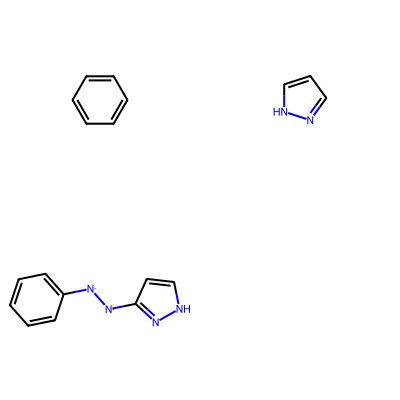

In [6]:
fragsmile, fragmol, fragap, fraparent_, fraparentmol_ = generate_unique_frag(smiles['mol'].iloc[0],patterns)
mol = smiles['mol'].iloc[0]
fragmols_plot = fragmol.copy()
fragmols_plot = np.array(fragmols_plot, dtype=object)
fragmols_plot = np.append(fragmols_plot, mol)
img = Draw.MolsToGridImage(fragmols_plot, molsPerRow=2)

img

Unique substituents detected: 194


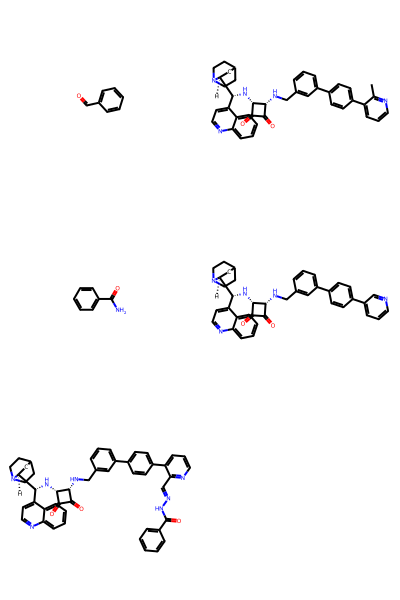

In [7]:

fragsmiles, fragmols, fragaps, fraparent, fraparentmol = [], [], [], [], []
for mol in smiles['mol']:
    fragsmile, fragmol, fragap, fraparent_, fraparentmol_ = generate_unique_frag(mol,patterns)
    fragsmiles += fragsmile
    fragmols += fragmol
    fragaps += fragap
    fraparent += fraparent_
    fraparentmol += fraparentmol_

fragsmiles, idx = np.unique(np.array(fragsmiles), return_index=True)
fragmols_plot = fragmol.copy()
fragmols_plot = np.array(fragmols_plot, dtype=object)
fragmols_plot = np.append(fragmols_plot, mol)
fragmols = np.array(fragmols, dtype=object)[idx]
fragaps = np.array(fragaps, dtype=int)[idx]
#fraparent = np.array(fraparent)[idx]
fraparentmol = np.array(fraparentmol)[idx]

print(f"Unique substituents detected: {fragsmiles.shape[0]}")
img = Draw.MolsToGridImage(fragmols_plot, molsPerRow=2)

img

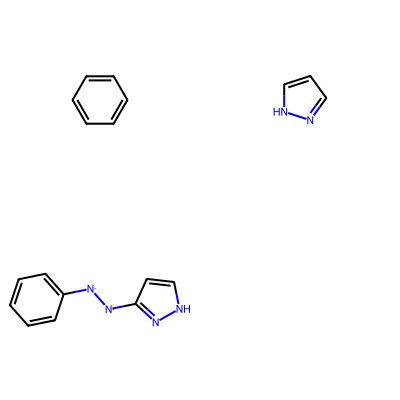

In [8]:
fragsmile, fragmol, fragap, fraparent_, fraparentmol_ = generate_unique_frag(smiles['mol'].iloc[0],patterns)
mol = smiles['mol'].iloc[0]
fragmols_plot = fragmol.copy()
fragmols_plot = np.array(fragmols_plot, dtype=object)
fragmols_plot = np.append(fragmols_plot, mol)
img = Draw.MolsToGridImage(fragmols_plot, molsPerRow=2)

img

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import copy
import os

# Cheminformatics stack
import rdkit
from rdkit import Chem
from rdkit.Chem import rdDistGeom
from rdkit.Chem import AllChem
from rdkit.Chem import FragmentMatcher
from rdkit.Chem import rdFMCS
from glob import glob

# For segfault
import faulthandler
import signal
from subprocess import Popen, PIPE


Unique substituents detected: 194


[12:20:24] WARNING: bond found with stereo spec but no stereo atoms
[12:20:24] WARNING: bond found with stereo spec but no stereo atoms
[12:20:24] WARNING: bond found with stereo spec but no stereo atoms
[12:20:24] WARNING: bond found with stereo spec but no stereo atoms
[12:20:24] WARNING: bond found with stereo spec but no stereo atoms
[12:20:24] WARNING: bond found with stereo spec but no stereo atoms


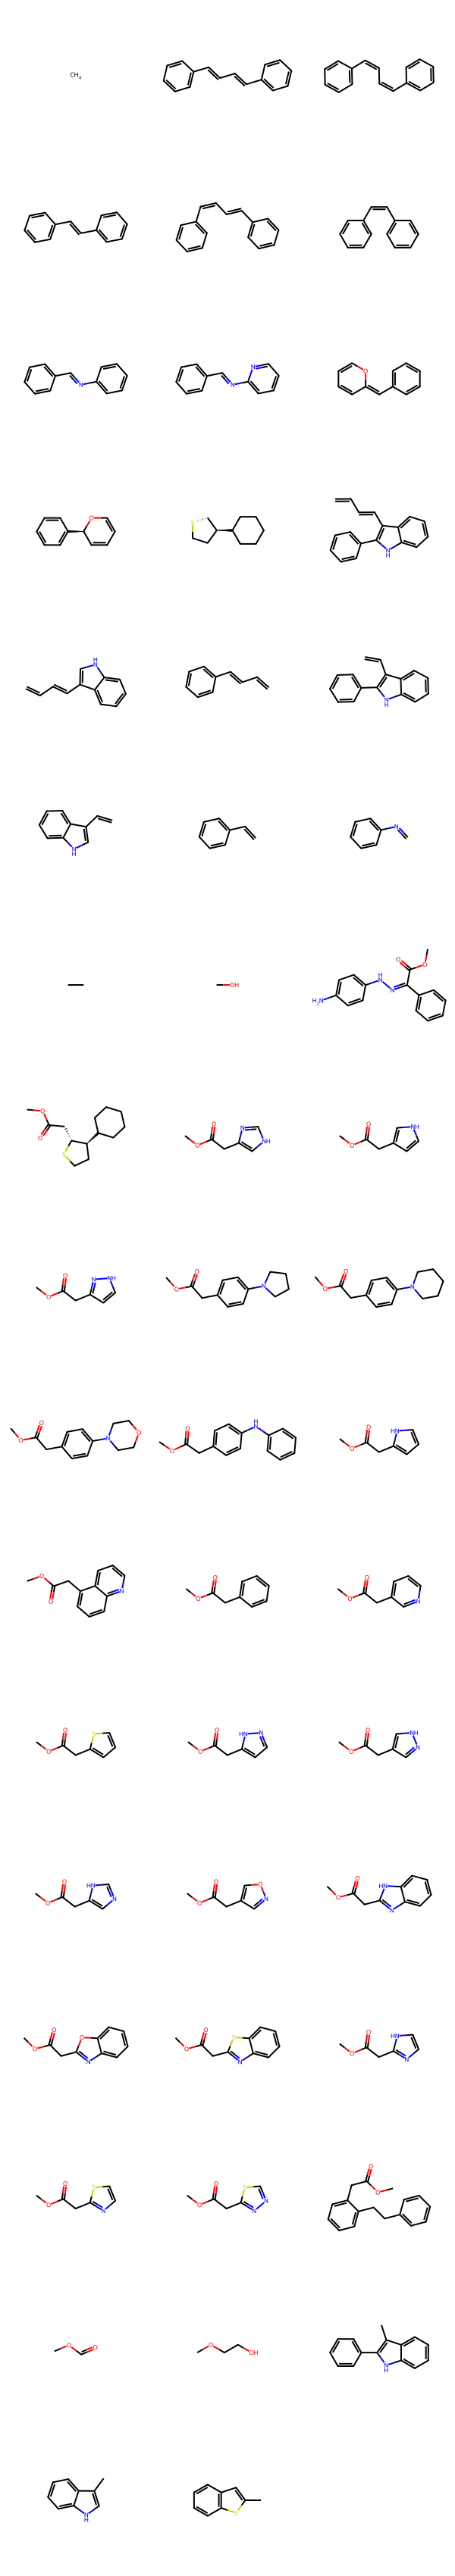

In [10]:
print(f"Unique substituents detected: {fragsmiles.shape[0]}")
img = Draw.MolsToGridImage(fragmols[:50], molsPerRow=3)
img

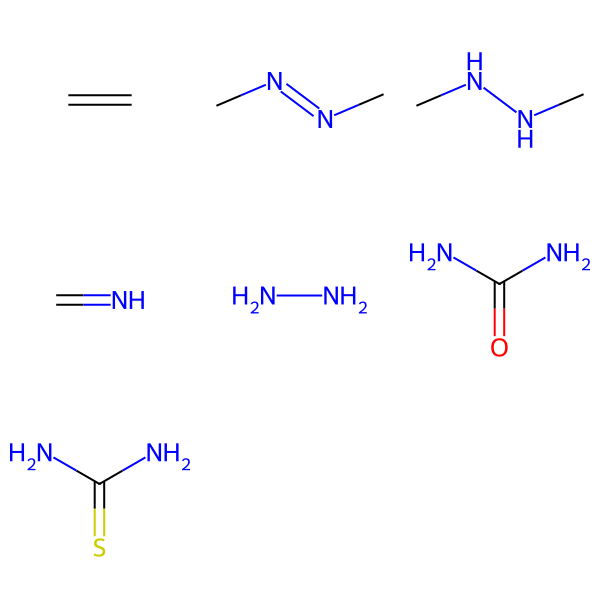

In [11]:
# Classification rules

patterns = [
    "C=C",
    "CN=NC",
    "CNNC",
    #"N=C",
    "C=N",
    'NN',
    "NC(N)=O",
    "NC(N)=S",
]
# draw mol patterns
mol_patterns = np.array([Chem.MolFromSmiles(smi) for smi in patterns], dtype=object)
from rdkit import Chem
from rdkit.Chem import Draw
img = Draw.MolsToGridImage(mol_patterns, molsPerRow=3)
img

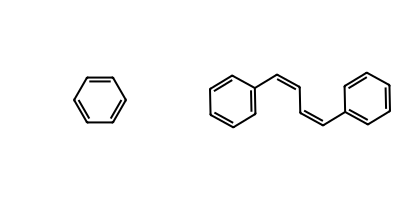

In [12]:
mol = fragmols[2]
fragsmile, fragmol, fragap, fraparent_, fraparentmol_ = generate_unique_frag(mol,patterns)
fragmols_plot = fragmol.copy()
fragmols_plot = np.array(fragmols_plot, dtype=object)
fragmols_plot = np.append(fragmols_plot, mol)
img = Draw.MolsToGridImage(fragmols_plot, molsPerRow=2)

img

In [13]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D, rdDepictor
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
from rdkit.Chem import rdRascalMCES
from rdkit import rdBase
rdDepictor.SetPreferCoordGen(True)
print(rdBase.rdkitVersion)

2023.09.1


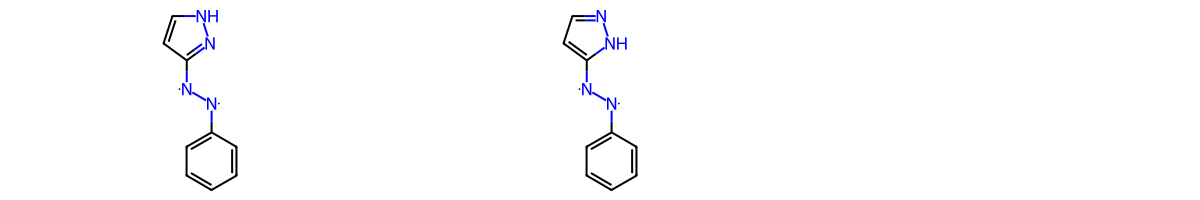

In [14]:
mol1 = smiles['mol'].iloc[0]
mol2 = smiles['mol'].iloc[2]
Draw.MolsToGridImage([mol1,mol2],subImgSize=(400,200))


In [ ]:
results = rdRascalMCES.FindMCES(mol1, mol2)
if len(results)>0:
    res = results[0]
    print(f'MCES SMARTS : {res.smartsString}')
    print(f'Matching Bonds : {res.bondMatches()}')
    print(f'Matching Atoms : {res.atomMatches()}')
else:   
    print('No MCES found')



In [ ]:
def extractHighlights(res):
    bondHighlights1 = {}
    bondHighlights2 = {}
    for bondPair in res.bondMatches():
        bondHighlights1[bondPair[0]] = (1.0, 0.0, 0.0)
        bondHighlights2[bondPair[1]] = (1.0, 0.0, 0.0)
    atomHighlights1 = {}
    atomHighlights2 = {}
    for atomPair in res.atomMatches():
        atomHighlights1[atomPair[0]] = (1.0, 0.0, 0.0)
        atomHighlights2[atomPair[1]] = (1.0, 0.0, 0.0)
    return bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2

def drawMCESMatch(mol1, bondHighlights, atomHighlights, highlightNonmatches=(0.3,0.3,1.0)):    
    d = rdMolDraw2D.MolDraw2DSVG(500, 250)
    if highlightNonmatches:
        for bnd in mol1.GetBonds():
            if bnd.GetIdx() not in bondHighlights:
                bondHighlights[bnd.GetIdx()] = highlightNonmatches
    d.DrawMolecule(mol1,highlightAtoms=atomHighlights.keys(),highlightBonds=bondHighlights.keys(),
                   highlightAtomColors=atomHighlights,highlightBondColors=bondHighlights)
    d.FinishDrawing()
    return d


bondHighlights1, bondHighlights2, atomHighlights1, atomHighlights2 = extractHighlights(res)
d = drawMCESMatch(mol1, bondHighlights1, atomHighlights1)
SVG(d.GetDrawingText())

In [ ]:
d = drawMCESMatch(mol2, bondHighlights2, atomHighlights2)
SVG(d.GetDrawingText())

In [28]:
frag_smiles_[0]

'O=C(NN=C[*:1])c1ccccc1'

In [40]:
from rdkit.Chem import rdMMPA
def fragment_mols_to_3_parts(mols_list):
    linker_list = []
    Left_block = []
    Right_block = []
    for mols in mols_list:
        frag3 = rdMMPA.FragmentMol(mols)

        for frag in frag3:
            if frag[0] is not None:
                #display(Draw.MolsToGridImage(frag3[1]))
                linker_list.append(frag[0])
                frag_smiles_ = Chem.MolToSmiles(frag3[1][1]).split('.')
                if len(frag_smiles_) == 2:
                    if '*:1' in frag_smiles_[0]:
                        Left_block.append( Chem.MolFromSmiles(frag_smiles_[0]))
                        Right_block.append( Chem.MolFromSmiles(frag_smiles_[1]))
                    else:
                        Left_block.append( Chem.MolFromSmiles(frag_smiles_[1]))
                        Right_block.append( Chem.MolFromSmiles(frag_smiles_[0]))
    print(' number of linkers:', len(linker_list))  
    print(' number of left blocks:', len(Left_block))
    print(' number of right blocks:', len(Right_block))
    df_linkers= pd.DataFrame({'linker':linker_list, 'smiles': [Chem.MolToSmiles(m) for m in linker_list]})
    df_linkers.drop_duplicates(subset=['smiles'],inplace=True) 
    print(' number of unique linkers:', df_linkers.shape[0])
    df_linkers.head()
    df_right_block = pd.DataFrame({'right_block':Right_block, 'smiles': [Chem.MolToSmiles(m) for m in Right_block]})
    df_right_block.drop_duplicates(subset=['smiles'],inplace=True)
    print(' number of unique right blocks:', df_right_block.shape[0])
    df_left_block = pd.DataFrame({'left_block':Left_block, 'smiles': [Chem.MolToSmiles(m) for m in Left_block]})
    df_left_block.drop_duplicates(subset=['smiles'],inplace=True)
    print(' number of unique left blocks:', df_left_block.shape[0])
    return df_linkers, df_left_block, df_right_block
df_linkers, df_left_block, df_right_block = fragment_mols_to_3_parts(smiles['mol'])

 number of linkers: 2070
 number of left blocks: 2070
 number of right blocks: 2070
 number of unique linkers: 767
 number of unique right blocks: 72
 number of unique left blocks: 101


In [36]:
df_linkers= pd.DataFrame({'linker':linker_list, 'smiles': [Chem.MolToSmiles(m) for m in linker_list]})
df_linkers.drop_duplicates(subset=['smiles'],inplace=True) 
print(' number of unique linkers:', df_linkers.shape[0])
df_linkers.head()
df_right_block = pd.DataFrame({'right_block':Right_block, 'smiles': [Chem.MolToSmiles(m) for m in Right_block]})
df_right_block.drop_duplicates(subset=['smiles'],inplace=True)
print(' number of unique right blocks:', df_right_block.shape[0])
df_left_block = pd.DataFrame({'left_block':Left_block, 'smiles': [Chem.MolToSmiles(m) for m in Left_block]})
df_left_block.drop_duplicates(subset=['smiles'],inplace=True)
print(' number of unique left blocks:', df_left_block.shape[0])
df_linkers.head()


 number of unique linkers: 767
 number of unique right blocks: 72
 number of unique left blocks: 101


,linker,smiles
0,<rdkit.Chem.rdchem.Mol object at 0x0000028BFE5...,[N]([N][*:2])[*:1]
15,<rdkit.Chem.rdchem.Mol object at 0x0000028BFE5...,c1cc([*:2])ccc1[*:1]
16,<rdkit.Chem.rdchem.Mol object at 0x0000028BFE5...,c1cc([*:1])ccc1[N][N][*:2]
20,<rdkit.Chem.rdchem.Mol object at 0x0000028BFE5...,c1cc(N[*:2])ccc1[N][N][*:1]
22,<rdkit.Chem.rdchem.Mol object at 0x0000028BFE5...,c1cc([*:1])ccc1N[*:2]


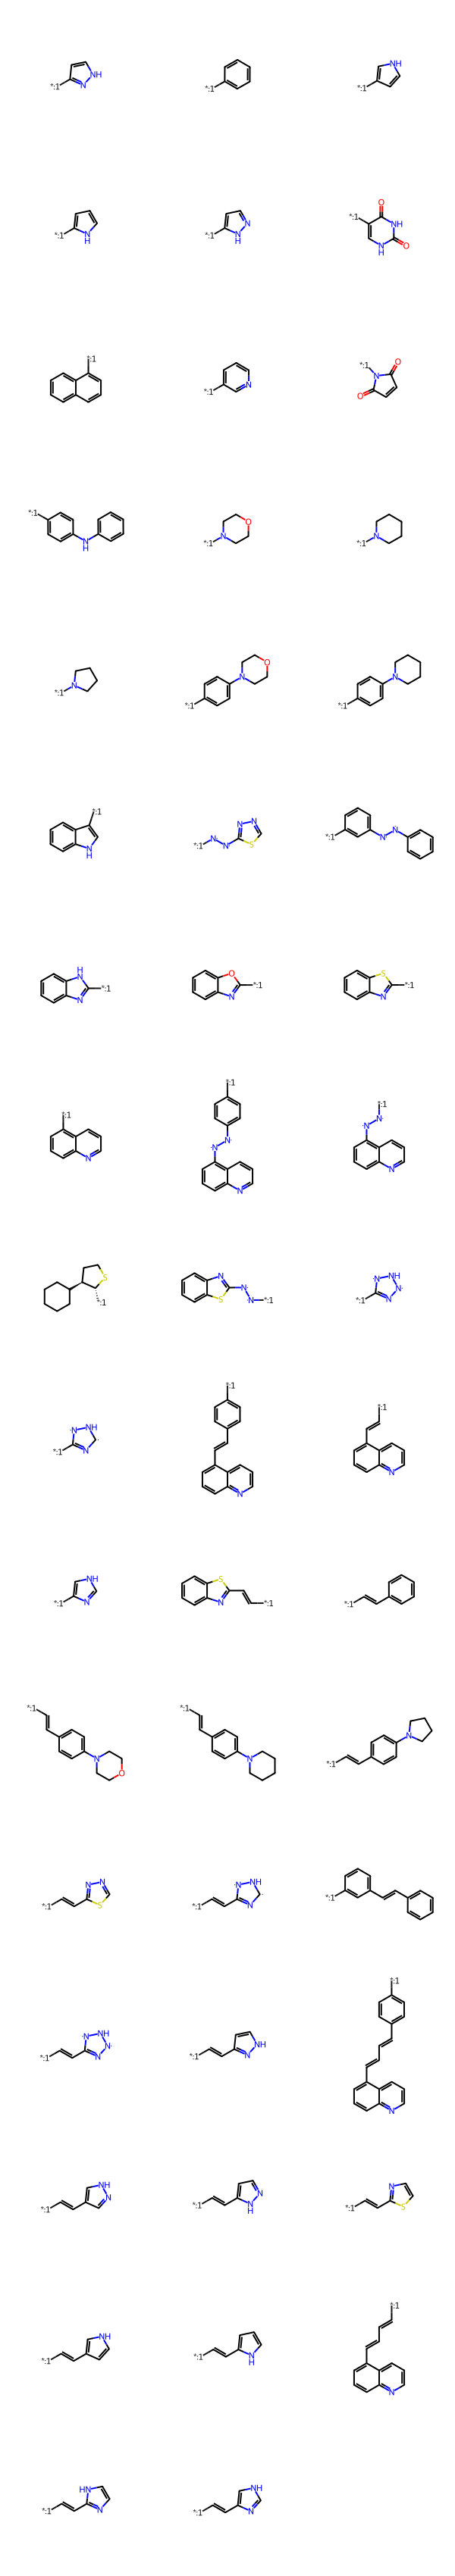

In [42]:
display(Draw.MolsToGridImage(df_left_block['left_block'][:50]))

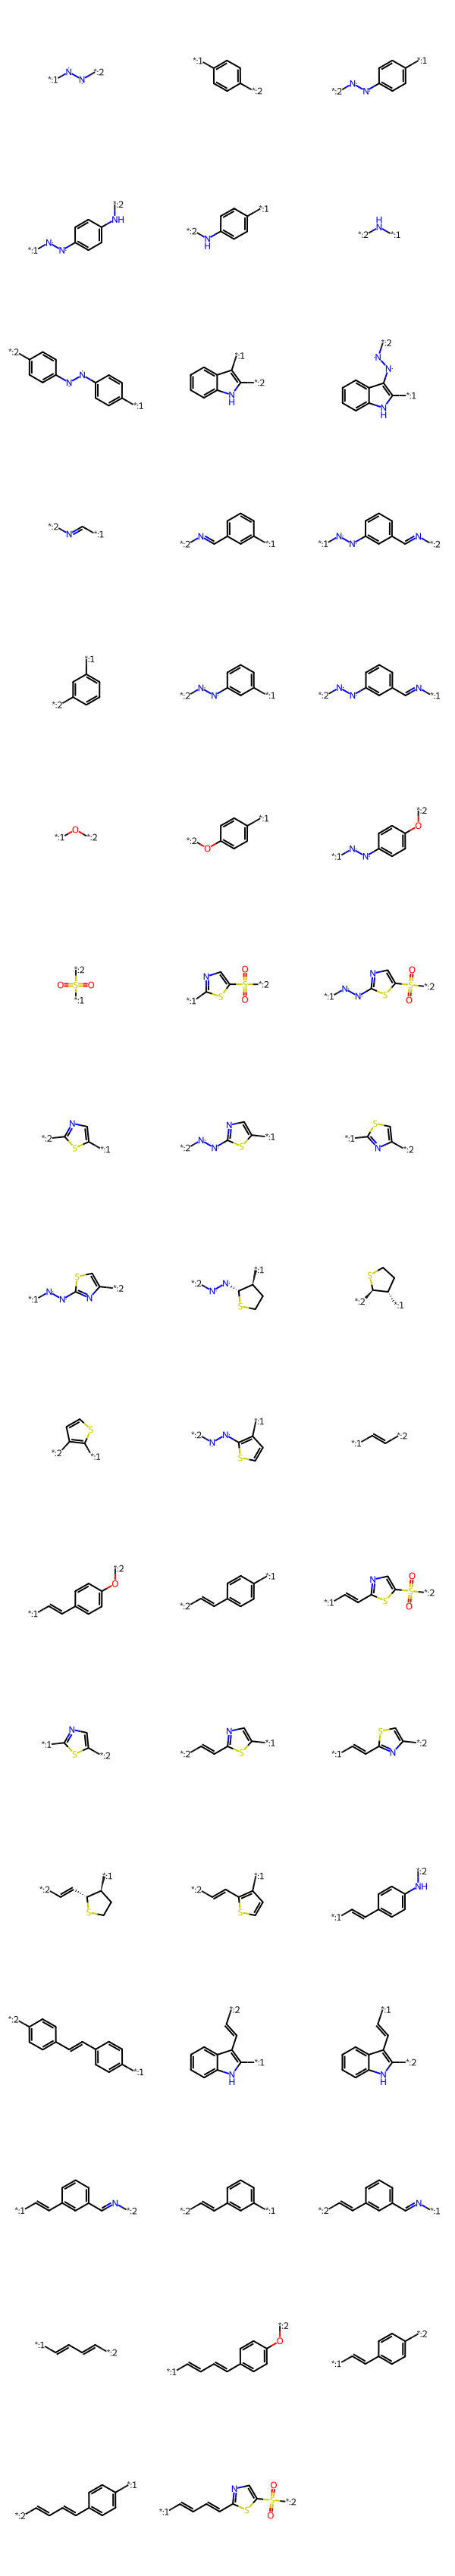

In [43]:
display(Draw.MolsToGridImage(df_linkers['linker'][:50]))